# TensorFlow, Keras with ResNet50: People Age-Image Regressor (Part 3)
In this project, a model is trained to predict the age of people in pictures. The pretrained model 'ResNet50' is used. This document is the third part of the whole training process.

## Iteration 3: Model retraining with data augmentation, learning_rate = 1e-4 (smaller) and fine-tuning (last 10 layers)

In [1]:
# (height, width, channels)
input_shape = (224, 224, 3)
batch_size = 8
learning_rate = 1e-4
neurons = 128
path_dataset = '../dataset'
folder_models = '../models'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

2025-10-02 19:42:12.088961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 19:42:17.632898: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-02 19:42:17.641272: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-02 19:42:30.542248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Find how many images exist
imgs = os.listdir(path_dataset)
num_imgs = len(imgs)
print(f'Total images found: {num_imgs}')

Total images found: 24101


### Data augmentation

In [4]:
def extract_age_from_filename(filename):
    """Extrae la edad desde el primer número del nombre del archivo."""
    return float(filename.split('_')[0])

def create_dataframe_from_directory(directory):
    """Crea un DataFrame con nombres de archivo y edades como etiquetas."""
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    ages = [extract_age_from_filename(f) for f in filenames]
    df = pd.DataFrame({'filename': filenames, 'age': ages})
    return df

In [5]:
def load_regression_data(path, input_shape=input_shape, batch_size=batch_size, seed=123, validation_split=0.2):
    """Crea generadores de imágenes para regresión lineal."""
    height, width = input_shape[:2]
    df = create_dataframe_from_directory(path)

    # Separar en entrenamiento y validación
    train_df = df.sample(frac=1 - validation_split, random_state=seed)
    val_df = df.drop(train_df.index)

    datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0.1,
        horizontal_flip=True, vertical_flip=False,
        height_shift_range=0.1, width_shift_range=0.1,
        brightness_range=(0.8, 1.2), rotation_range=10)

    train_data = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path,
        x_col='filename',
        y_col='age',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='raw',  # For regression
        seed=seed
    )
    
    datagen_val = ImageDataGenerator(rescale=1.0/255)
    val_data = datagen_val.flow_from_dataframe(
        dataframe=val_df,
        directory=path,
        x_col='filename',
        y_col='age',
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='raw',
        seed=seed
    )

    return train_data, val_data

In [6]:
# Split training and validation datasets
train, val = load_regression_data(path_dataset)

print(f"Training images: {train.samples}")
print(f"Validation images: {val.samples}")

Found 19279 validated image filenames.
Found 4820 validated image filenames.
Training images: 19279
Validation images: 4820


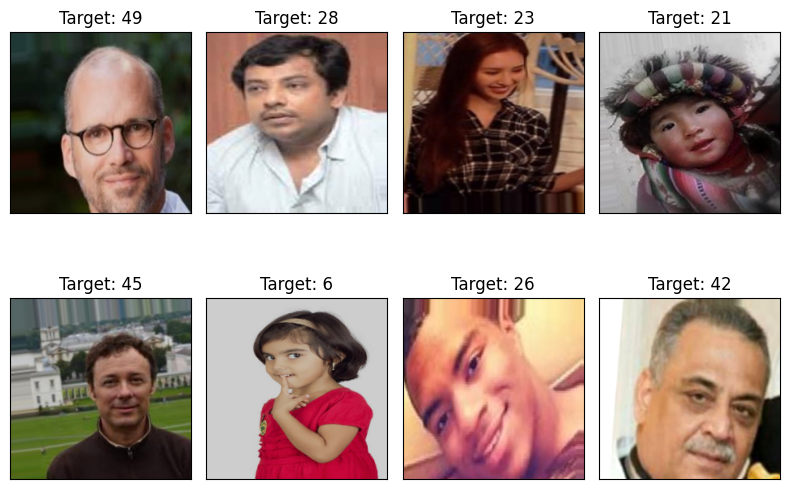

(8, 224, 224, 3)


In [7]:
# Obtain images and target
images, labels = next(train)

# Show 8 training images (batch_size=8)
figure, axes = plt.subplots(nrows=2,ncols=4, figsize=(8, 6))
for item in zip(axes.ravel(), images, labels):
    axes, image, target = item
    axes.imshow(image)
    axes.set_title(f'Target: {target:.0f}')
    axes.set_xticks([])
    axes.set_yticks([])
plt.tight_layout()
plt.show()

# Image dimensions
print(images.shape)

### Model retraining, learning_rate=1e-4 and partial fine-tuning (iteration 3)

In [9]:
def train_model(model, train_data, val_data, epochs, version_model, folder_models=folder_models):
    """Function to train the model and save the best one
    according to the min MAE."""
    file_name = os.path.join(folder_models,f'regression_model_v{version_model}.h5')
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=0),
        ModelCheckpoint(file_name, monitor='val_mae', save_best_only=True, mode='min', verbose=1)
    ]

    history = model.fit(train_data, validation_data=val_data,
              epochs=epochs, callbacks=callbacks, verbose=2)

    return model, history

In [10]:
# Load model v2
model_v3 = load_model(os.path.join(folder_models,'regression_model_v2.h5'))
model_v3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23850113 (90.98 MB)
Trainable params: 262401 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [11]:
epochs = 20
version_model = 3
print(f"Parameters: batch_size = {batch_size}, learning_rate = {learning_rate}, neurons = {neurons}, epochs = {epochs}")

Parameters: batch_size = 8, learning_rate = 0.0001, neurons = 128, epochs = 20


In [12]:
# last 10 layers
for layer in model_v3.layers[0].layers[-10:]:
    layer.trainable = True

# Recompile
model_v3.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='mse', metrics=['mae'])

In [13]:
print(f"TensorFlow Version: {tf.__version__}")

# Ensure GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    print("GPU is available and memory growth is enabled.")
else:
    print("GPU not available, training will be on CPU.")
    
# Retrain the model
model_v3, history_stage3 = train_model(model_v3, train, val, epochs=epochs, version_model=version_model)

TensorFlow Version: 2.13.1
GPU not available, training will be on CPU.
Epoch 1/20


2025-10-02 19:44:51.185368: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-10-02 19:44:52.028724: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-10-02 19:44:52.060993: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26615808 exceeds 10% of free system memory.
2025-10-02 19:44:52.093184: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.
2025-10-02 19:44:52.105590: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25690112 exceeds 10% of free system memory.



Epoch 1: val_mae improved from inf to 16.30897, saving model to ../models/regression_model_v3.h5


/home/ant/TensorFlow-Keras-ResNet50-HuggingFace/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2410/2410 - 2608s - loss: 403.6296 - mae: 15.5994 - val_loss: 401.2569 - val_mae: 16.3090 - lr: 1.0000e-04 - 2608s/epoch - 1s/step
Epoch 2/20

Epoch 2: val_mae improved from 16.30897 to 14.97952, saving model to ../models/regression_model_v3.h5
2410/2410 - 2357s - loss: 371.3909 - mae: 14.9158 - val_loss: 362.6502 - val_mae: 14.9795 - lr: 1.0000e-04 - 2357s/epoch - 978ms/step
Epoch 3/20

Epoch 3: val_mae did not improve from 14.97952
2410/2410 - 2128s - loss: 359.6628 - mae: 14.6574 - val_loss: 468.8742 - val_mae: 17.5163 - lr: 1.0000e-04 - 2128s/epoch - 883ms/step
Epoch 4/20

Epoch 4: val_mae improved from 14.97952 to 14.03672, saving model to ../models/regression_model_v3.h5
2410/2410 - 2019s - loss: 350.5907 - mae: 14.4439 - val_loss: 343.8597 - val_mae: 14.0367 - lr: 1.0000e-04 - 2019s/epoch - 838ms/step
Epoch 5/20

Epoch 5: val_mae did not improve from 14.03672
2410/2410 - 2188s - loss: 349.3101 - mae: 14.3902 - val_loss: 518.7184 - val_mae: 17.5227 - lr: 1.0000e-04 - 2188s/epoch 

**Result 3:** val_mae=12.7.

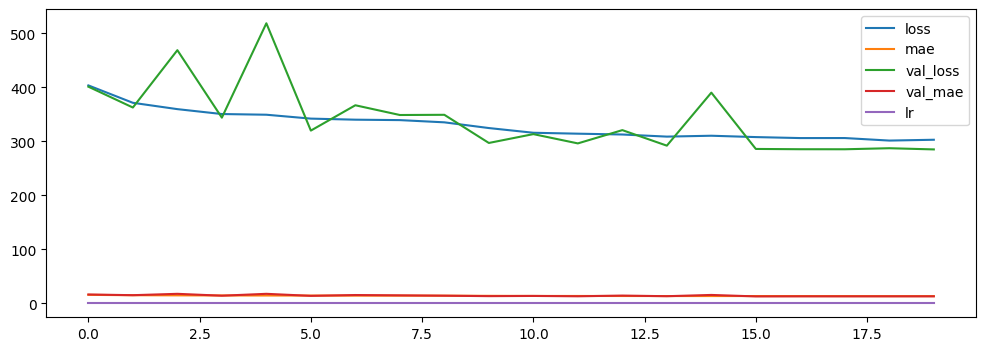

In [17]:
pd.DataFrame(history_stage3.history).plot(figsize=(12, 4))
plt.show()

In [ ]:
# Save model
# model.save(os.path.join(folder_models,f'binary_model_v{version_model}.keras'))

In the next iteration, the model will be retrained, data augmentation and fine-tuning (the last 20 layers) will be performed.